In [1]:
import mygan
import random
import torch
import torchvision.transforms as transforms
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


#### Transforming and loading dataset

In [2]:
extension = '.png'
dataroot = 'cat-dataset'

dataset = mygan.MyImageDataSet(root = dataroot, extension = extension,
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # original images range is 0-1, after the trans it will be -1 1
    ]))

print(len(dataset))
dataset[0].shape

29843


torch.Size([3, 64, 64])

In [3]:
# confirm pixel range is -1 1
min = 0.5
max = 0.5
for i in range(len(dataset)):
    pixels = asarray(dataset[i])
    if pixels.min() < min:
        min = pixels.min()
    if pixels.max() > max:
        max = pixels.max()

print(min)
print(max)

-1.0
1.0


In [4]:
# Create the dataloader
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [6]:
# Useful if you have GPU and you want to use it
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cpu')

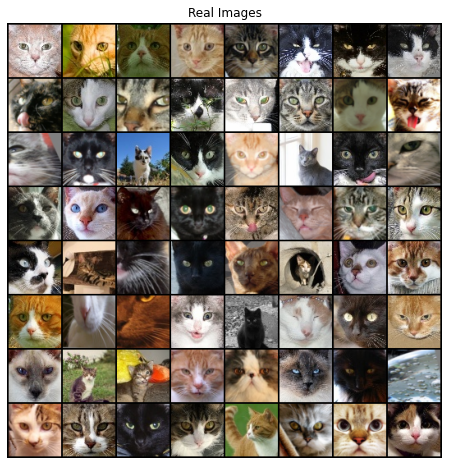

In [7]:
# Plot some training images
# iter() calls the __iter__() method on the dataloader which returns an iterator
# next() then calls the __next__() method on that iterator to get the first iteration
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
# normalize = True shifts the image to the range (0, 1), by the min and max values computed from the tensors (-1, 1)
# tensor.cpu() moves it back to memory accessible to the CPU
# images have shape [C x H x W] with indices (0->C, 1->H, 2->W), and needs to be transposed in [H x W x C] with axis permutation (1, 2, 0)
# imshow takes an image [H x W x C], where H = #rows and W = #cols, and values are 0-1 float or 0-255 int
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Generator

In [8]:
ngpu = 0

# Create the generator
netG = mygan.Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(mygan.weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTr

### Discriminator

In [9]:
# Create the Discriminator
netD = mygan.Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(mygan.weights_init)

# Print the model
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyR

### Loss and Optimizers

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Size of z latent vector (i.e. size of generator input)
nz = 100
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# some dataloader useful printings
print('number of batches: {}'.format(len(dataloader)))

for i, data in enumerate(dataloader):
    real_cpu = data.to(device) # batch of images
    print('example batch shape: {}'.format(real_cpu.shape))
    b_size = real_cpu.size(0)
    print('number of elements in a batch: {}'.format(b_size))
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    print('label shape: {}'.format(label.shape))
    output = netD(real_cpu).view(-1)
    print('discriminator output shape: {}'.format(output.shape))
    D_x = output.mean().item()
    print('taking mean item: {}'.format(D_x))
    break

number of batches: 233
example batch shape: torch.Size([128, 3, 64, 64])
number of elements in a batch: 128
label shape: torch.Size([128])
discriminator output shape: torch.Size([128])
taking mean item: 0.5620386004447937


### Training

In [13]:
# Training Loop
num_epochs = 50

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0): # for each batch:

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # if we do not set grads to 0, PyTorch accumulates them on subsequent backward passes
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0) # num of images in the batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # tensor of ones (128,)
        # Forward pass real batch through D
        # view(-1): flattening the output
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item() # taking the tensor value

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        #
        # Detaching fake from the graph is necessary to avoid forward-passing the noise through G
        # when we actually update the generator. If we do not detach, then, although fake is not 
        # needed for gradient update of D, it will still be added to the computational graph and 
        # as a consequence of backward pass which clears all the variables in the graph 
        # (retain_graph=False by default), fake won't be available when G is updated.
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

37	D(G(z)): 0.1349 / 0.0306
[3/50][151/233]	Loss_D: 0.7409	Loss_G: 3.5307	D(x): 0.5942	D(G(z)): 0.0640 / 0.0682
[3/50][201/233]	Loss_D: 0.8265	Loss_G: 5.9346	D(x): 0.8551	D(G(z)): 0.4079 / 0.0068
[4/50][1/233]	Loss_D: 0.5172	Loss_G: 4.1578	D(x): 0.8436	D(G(z)): 0.2371 / 0.0227
[4/50][51/233]	Loss_D: 0.4446	Loss_G: 3.9646	D(x): 0.7839	D(G(z)): 0.0978 / 0.0370
[4/50][101/233]	Loss_D: 0.7752	Loss_G: 5.4140	D(x): 0.9239	D(G(z)): 0.4173 / 0.0087
[4/50][151/233]	Loss_D: 0.7246	Loss_G: 3.4206	D(x): 0.5896	D(G(z)): 0.0401 / 0.0692
[4/50][201/233]	Loss_D: 0.3705	Loss_G: 4.6478	D(x): 0.8030	D(G(z)): 0.0695 / 0.0200
[5/50][1/233]	Loss_D: 1.4661	Loss_G: 2.0259	D(x): 0.3904	D(G(z)): 0.0058 / 0.2955
[5/50][51/233]	Loss_D: 0.5742	Loss_G: 3.9012	D(x): 0.7965	D(G(z)): 0.2285 / 0.0386
[5/50][101/233]	Loss_D: 0.6035	Loss_G: 3.3253	D(x): 0.7104	D(G(z)): 0.1258 / 0.0719
[5/50][151/233]	Loss_D: 0.6059	Loss_G: 3.8520	D(x): 0.7264	D(G(z)): 0.1474 / 0.0411
[5/50][201/233]	Loss_D: 0.5099	Loss_G: 3.3601	D(x): 0.

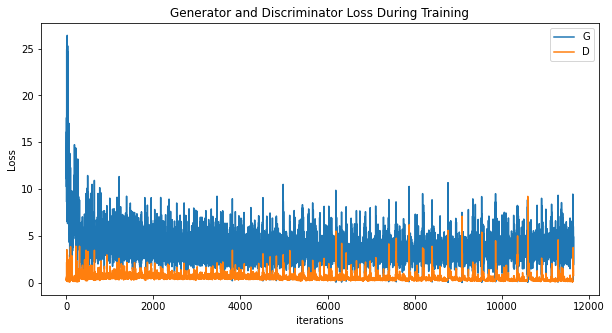

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

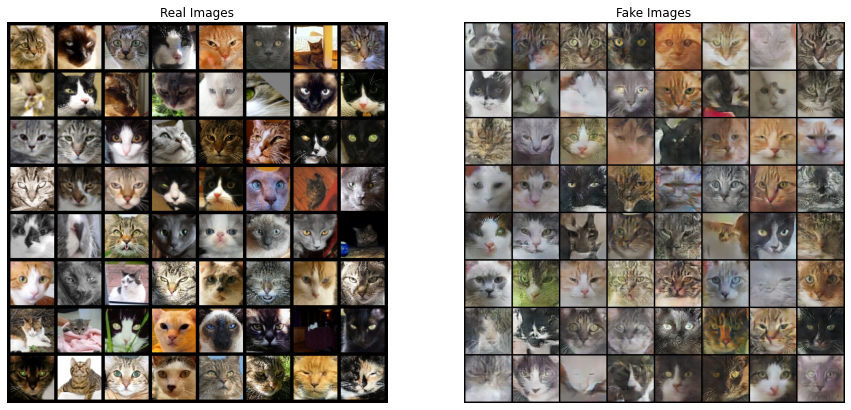

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()